### Make sure gpu is working

In [3]:
!nvidia-smi

Wed May 21 14:12:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Extract Data

In [4]:
!unzip ./drive/MyDrive/sports.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/rings/156.jpg  
  inflating: data/train/rings/157.jpg  
   creating: data/train/rock climbing/
  inflating: data/train/rock climbing/001.jpg  
  inflating: data/train/rock climbing/002.jpg  
  inflating: data/train/rock climbing/003.jpg  
  inflating: data/train/rock climbing/004.jpg  
  inflating: data/train/rock climbing/005.jpg  
  inflating: data/train/rock climbing/006.jpg  
  inflating: data/train/rock climbing/007.jpg  
  inflating: data/train/rock climbing/008.jpg  
  inflating: data/train/rock climbing/009.jpg  
  inflating: data/train/rock climbing/010.jpg  
  inflating: data/train/rock climbing/011.jpg  
  inflating: data/train/rock climbing/012.jpg  
  inflating: data/train/rock climbing/013.jpg  
  inflating: data/train/rock climbing/014.jpg  
  inflating: data/train/rock climbing/015.jpg  
  inflating: data/train/rock climbing/016.jpg  
  inflating: data/train/rock climbing/017.jpg  
  inflating: d

### Review data

In [5]:
import pandas as pd
import numpy as np
import cv2

In [6]:
df = pd.read_csv('data/sports.csv')
df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14487,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14488,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


In [21]:
## get how mnay images each class has
df['class id'].value_counts()

,count
class id,
31,201
32,200
58,199
7,184
41,182
...,...
44,112
3,109
99,108


In [23]:
### get count of different classes
df['class id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [7]:
import matplotlib.pyplot as plt
def show_image(image_path):
  img = cv2.imread(image_path)
  ### show image shape (dimensions)
  img.shape
  plt.imshow(img)

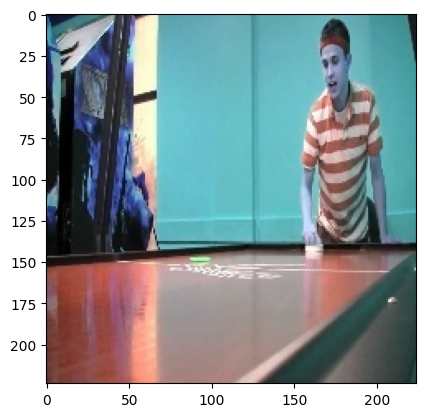

In [9]:
show_image('data/'+df['filepaths'][0])

In [10]:
df['labels'][0]

'air hockey'

## Start Training

In [1]:
import cv2
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0


EPOCHS = 20
IMG_WIDTH = 224
IMG_HEIGHT = 224
TEST_SIZE = 0.4
NUM_CATEGORIES = 100
MAP = {}


def main():

    global MAP
    # Load  csv that contains the data into a dataframe object
    df = pd.read_csv('data/sports.csv')
    MAP = map_class_id_to_label(df)

    # Get image arrays and labels for all image files
    images, class_ids = load_data(df)

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        np.array(images), np.array(class_ids), test_size=TEST_SIZE
    )

    # Get a compiled neural network
    model_relu = get_model_with_relu_hidden_layer()
    model_tanh = get_model_with_tanh_hidden_layer()

    # Print Model summaries (layers)
    print(model_relu.summary())
    print(model_tanh.summary())

    # Fit model on training data
    print(f'training relu model ...')
    model_relu.fit(x_train, y_train, epochs=EPOCHS)

    print(f'training tanh model ...')
    model_tanh.fit(x_train, y_train, epochs=EPOCHS)

    # Evaluate neural network performance
    print(f"relu model evaluation: ")
    model_relu.evaluate(x_test,  y_test, verbose=2)

    print(f"tanh model evaluation: ")
    model_tanh.evaluate(x_test,  y_test, verbose=2)

    model_relu.save("model_relu.h5")
    model_tanh.save('model_tanh.h5')
    print(f"Saved Models")


def map_class_id_to_label(df: pd.DataFrame):
    mapper = {}
    for class_id, label in zip(df['class id'], df['labels']):
        mapper[class_id] = label
    return mapper


def load_data(df: pd.DataFrame):
    """
        loads data from a dataframe that has an image class
        and the associated image file path
    """
    images = []
    class_ids = []
    for path, class_id in zip(df['filepaths'], df['class id']):
        image = cv2.imread("data/"+path)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        images.append(image)
        class_ids.append(class_id)
    return (images, class_ids)



def get_model_with_relu_hidden_layer():
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    base_model = EfficientNetB0(input_shape=(
        IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = tf.keras.models.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # loss function
        metrics=["accuracy"]
    )
    return model


def get_model_with_tanh_hidden_layer():
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    base_model = EfficientNetB0(input_shape=(
        IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = tf.keras.models.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation="tanh"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # loss function
        metrics=["accuracy"]
    )
    return model



In [2]:
main()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,226,439 (16.12 MB)

 Trainable params: 176,868 (690.89 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,226,439 (16.12 MB)

 Trainable params: 176,868 (690.89 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
training relu model ...
Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.2067 - loss: 3.6237
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6515 - loss: 1.3085
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7591 - loss: 0.8754
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8082 - loss: 0.7006
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8313 - loss: 0.5775
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8476 - loss: 0.5361
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8657 - loss: 0.4665
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8790 - loss: 0.4162
Epoch 9/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8847 - loss: 0.3863
Epoch 10/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8884 - loss: 0.3614
Epoch 11/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9109 - loss: 0.2998
Epoc

Saved Models


### Test model with images

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class is weightlifting
Original class is weightlifting
Model have predicted correctly !!


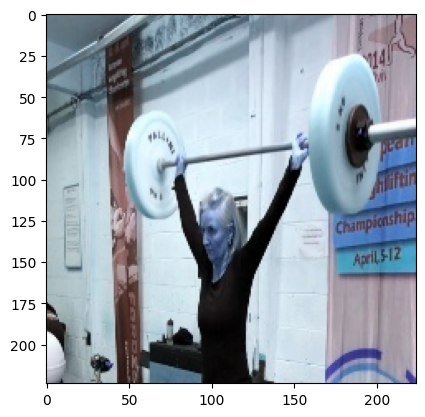

In [16]:
import random
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = np.expand_dims(image, axis=0)
    return image


def predict(model, image):
    global MAP
    if len(MAP) == 0:
        MAP = map_class_id_to_label(pd.read_csv('data/sports.csv'))

    predicted_class = np.argmax(model.predict(image)[0])
    print(f"Predicted class is {MAP[predicted_class]}")
    return MAP[predicted_class]


def load_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model


def test(image_path, model_path , original_class):
    model = load_model(model_path)
    image = get_image(image_path)
    prediction = predict(model, image)
    print(f"Original class is {original_class}")
    if prediction == original_class:
      print(f"Model have predicted correctly !!")
    else:
      print(f'That was an inaccuracy')


first_idx = random.randint(0, len(df))


show_image('data/' + df['filepaths'][first_idx])
test('data/'+ df['filepaths'][first_idx], 'model_relu.h5', df['labels'][first_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class is surfing
Original class is surfing
Model have predicted correctly !!


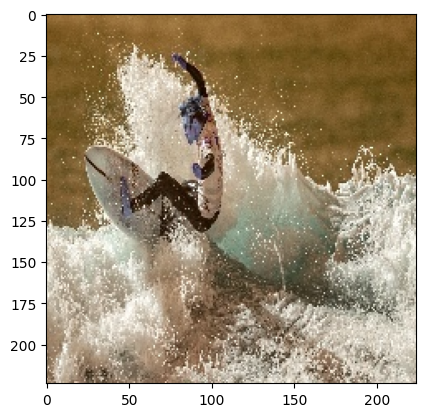

In [17]:
second_idx = random.randint(0, len(df))
show_image('data/' + df['filepaths'][second_idx])
test('data/'+ df['filepaths'][second_idx], 'model_tanh.h5', df['labels'][second_idx])